In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

## Model Architecture
<!-- <img src="./images/model-architecture.png" width="400"> -->
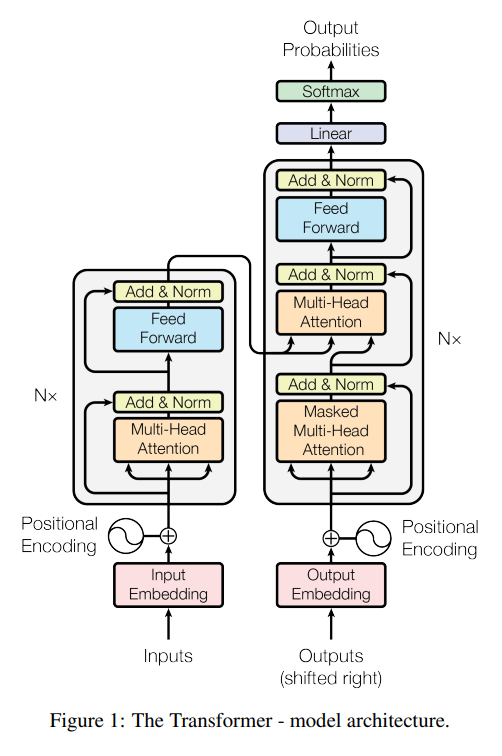


In [34]:
src_vocab_size = 3000
tgt_vocab_size = 3000
d_model = 512
d_pff = 512 * 4
max_len = 100
dropout = 0.1
n_heads = 8
n_layers = 6
batch_size = 16

## Embedding

In [35]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, dropout, use_positional_embedding=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_len = max_len
        self.use_positional_embedding = use_positional_embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.dropout = nn.Dropout(dropout)
        
        if self.use_positional_embedding:
            self.positional_embedding = nn.Embedding(max_len, d_model)
        else:
            self.positional_encoding = self.get_positional_encoding(self.max_len, self.d_model)
            self.positional_encoding.requires_grad_(False)
            self.register_buffer('positional_encoding_buffer', self.positional_encoding)

    def get_positional_encoding(self, max_len, d_model):
        positional_encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        positional_encoding = positional_encoding.unsqueeze(0)

        return positional_encoding
        
    def forward(self, x):
        """
        input : (batch_size, max_len)
        output : (batch_size, max_len, d_model) 
        """
        embedding = self.embedding(x)
        if self.use_positional_embedding:
            positions = torch.arange(0, x.size(1)).expand(x.size(0), x.size(1)).to(x.device)
            embedding = embedding + self.positional_embedding(positions)
        else:
            embedding = embedding + self.positional_encoding[:, :x.size(1), :]

        return self.dropout(embedding)

# Test the revised class
embedding = TokenEmbedding(src_vocab_size, d_model, max_len, dropout)

# Forward pass
sample_input = torch.randint(0, src_vocab_size, (batch_size, max_len))
output = embedding(sample_input)

# Check the output shape [batch_size, seq_len, d_model]
output.shape

torch.Size([16, 100, 512])

## Multi-Head Attention

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.n_heads = n_heads # Number of heads
        # Make sure d_model is divisible by n_heads
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_k = d_model // n_heads # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    def attention(self, query, key, value, mask=None):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, n_heads, seq_len, d_k) --> (batch, n_heads, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 1, -1e9)
        attention_scores = F.softmax(attention_scores, dim=-1) # (batch, n_heads, seq_len, seq_len) # Apply softmax

        # (batch, n_heads, seq_len, seq_len) --> (batch, n_heads, seq_len, d_k)
        # return attention scores which can be used for visualization
        return attention_scores @ value

    def forward(self, q, k, v, mask=None):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # Split heads
        # (batch, seq_len, d_model) --> (batch, seq_len, n_heads, d_k) --> (batch, n_heads, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.n_heads, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.n_heads, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.n_heads, self.d_k).transpose(1, 2)

        # Calculate attention
        attn_out = self.attention(query, key, value, mask)
        
        # Combine all the heads together
        # (batch, n_heads, seq_len, d_k) --> (batch, seq_len, n_heads, d_k) --> (batch, seq_len, d_model)
        attn_out = attn_out.transpose(1, 2).contiguous().view(attn_out.shape[0], -1, self.d_model)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        attn_out = self.w_o(attn_out)
        return self.dropout(attn_out)

mha = MultiHeadAttention(d_model, n_heads, dropout)
mha_out = mha(output, output, output)
print(output.shape)
print(mha_out.shape)

torch.Size([16, 100, 512])
torch.Size([16, 100, 512])


## Pointwise Feed-Forward

In [37]:
class PointwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_pff, dropout):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_pff)
        self.linear_2 = nn.Linear(d_pff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear_2(self.dropout(self.relu(self.linear_1(x))))
        return self.dropout(x)

pff = PointwiseFeedForward(d_model, d_pff, dropout)
pff(output).shape

torch.Size([16, 100, 512])

## Encoder Layer

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_pff, dropout, norm_first=True):
        super().__init__()
        self.norm_first = norm_first
        
        # Multi-Head Attention layer
        self.mha = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Pointwise Feed-Forward layer
        self.pff = PointwiseFeedForward(d_model, d_pff, dropout)
        
        # Layer Normalization layers
        self.layernorm_1 = nn.LayerNorm(d_model)
        self.layernorm_2 = nn.LayerNorm(d_model)
    
    def forward(self, src, src_mask=None):
        # Multi-Head Attention sub-layer
        if self.norm_first:
            norm_src = self.layernorm_1(src)
            attn_out = src + self.mha(norm_src, norm_src, norm_src, src_mask)
            norm_attn_out = self.layernorm_2(attn_out)
            pff_out = attn_out + self.pff(norm_attn_out)
        else:
            attn_out = self.mha(src, src, src, src_mask)
            attn_out = self.layernorm_1(src + attn_out)
            pff_out = self.pff(attn_out)
            pff_out = self.layernorm_2(attn_out + pff_out)

        return pff_out

enc_layer = EncoderLayer(d_model, n_heads, d_pff, dropout)
enc_layer_out = enc_layer(output)
enc_layer_out.shape

torch.Size([16, 100, 512])

## Encoder

In [45]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, d_model, n_heads, d_pff, max_len, n_layers, dropout, norm_first=True):
        super(Encoder, self).__init__()
        self.norm_first = norm_first
        if norm_first:
            self.layernorm = nn.LayerNorm(d_model)
        # Source Token Embedding
        self.src_embedding = TokenEmbedding(src_vocab_size, d_model, max_len, dropout)
        
        # Encoder Layers
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_pff, dropout, norm_first=norm_first)
            for _ in range(n_layers)
        ])
        
    def forward(self, src, src_mask=None):
        # Source Token Embedding
        src = self.src_embedding(src)
        
        # Pass through each Encoder Layer
        for layer in self.layers:
            src = layer(src, src_mask)
        if self.norm_first:
            src = self.layernorm(src)
        
        return src

sample = torch.randint(0, src_vocab_size, (batch_size, max_len))
encoder = Encoder(src_vocab_size, d_model, n_heads, d_pff, max_len, n_layers, dropout, norm_first=True)

enc_out = encoder(sample)
enc_out.shape

torch.Size([16, 100, 512])

## Decoder Layer

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_pff, dropout, norm_first=True):
        super().__init__()
        self.norm_first = norm_first
        
        # Masked Multi-Head Attention layer
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Encoder-Decoder Multi-Head Attention layer
        self.enc_dec_mha = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Pointwise Feed-Forward layer
        self.pff = PointwiseFeedForward(d_model, d_pff, dropout)
        
        # Layer Normalization layers
        self.layernorm_1 = nn.LayerNorm(d_model)
        self.layernorm_2 = nn.LayerNorm(d_model)
        self.layernorm_3 = nn.LayerNorm(d_model)
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        if self.norm_first:
            norm_tgt = self.layernorm_1(tgt)
            masked_attn_out = tgt + self.masked_mha(norm_tgt, norm_tgt, norm_tgt, tgt_mask)
            
            norm_masked_attn_out = self.layernorm_2(masked_attn_out)
            enc_dec_attn_out = masked_attn_out + self.enc_dec_mha(norm_masked_attn_out, enc_out, enc_out, src_mask)
            
            norm_enc_dec_attn_out = self.layernorm_3(enc_dec_attn_out)
            pff_out = enc_dec_attn_out + self.pff(norm_enc_dec_attn_out)
        else:
            masked_attn_out = self.masked_mha(tgt, tgt, tgt, tgt_mask)
            masked_attn_out = self.layernorm_1(tgt + masked_attn_out)
            
            enc_dec_attn_out = self.enc_dec_mha(masked_attn_out, enc_out, enc_out, src_mask)
            enc_dec_attn_out = self.layernorm_2(masked_attn_out + enc_dec_attn_out)
            
            pff_out = self.pff(enc_dec_attn_out)
            pff_out = self.layernorm_3(enc_dec_attn_out + pff_out)
        
        return pff_out


dec_layer = DecoderLayer(d_model, n_heads, d_pff, dropout)
dec_layer(output, enc_layer_out).shape

torch.Size([16, 100, 512])

In [47]:
class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, d_model, n_heads, d_pff, dropout, n_layers, norm_first=True):
        super().__init__()
        self.norm_first = norm_first
        if norm_first:
            self.layernorm = nn.LayerNorm(d_model)
            
        self.tgt_embedding = TokenEmbedding(tgt_vocab_size, d_model, max_len, dropout)
        
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_pff, dropout, norm_first) for _ in range(n_layers)
        ])
            
    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        tgt = self.tgt_embedding(tgt)
        
        for layer in self.layers:
            tgt = layer(tgt, enc_out, src_mask, tgt_mask)
        if self.norm_first:
            tgt = self.layernorm(tgt)
            
        return tgt
    
tgt_sample = torch.randint(0, tgt_vocab_size, (batch_size, max_len))
print(enc_out.shape)
decoder = Decoder(tgt_vocab_size, d_model, n_heads, d_pff, dropout, n_layers, norm_first=True)
dec_out = decoder(tgt_sample, enc_out)

torch.Size([16, 100, 512])


## Generator

In [51]:
class Generator(nn.Module):
    def __init__(self, d_model, tgt_vocab_size) -> None:
        super().__init__()
        self.linear = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, x) -> None:
        # (batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
        return self.linear(x)

## Complete Model

In [54]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, n_heads, d_pff, max_len, n_layers, dropout, norm_first=True):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(src_vocab_size, d_model, n_heads, d_pff, max_len, n_layers, dropout, norm_first)
        self.decoder = Decoder(tgt_vocab_size, d_model, n_heads, d_pff, dropout, n_layers, norm_first)
        self.generator = Generator(d_model, tgt_vocab_size)
        
    def create_masks(self, src, tgt):
        # Source Mask
        # Shape: (batch_size, 1, 1, max_len)
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

        # Target Mask
        # Shape: (batch_size, 1, max_len, max_len)
        tgt_mask = torch.triu(torch.ones((tgt.size(1), tgt.size(1))), diagonal=1).bool()
        tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(1)
        tgt_padding_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = tgt_mask & tgt_padding_mask

        return src_mask, tgt_mask
    
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.create_masks(src, tgt)
        
        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        
        output = self.generator(dec_out)
        
        return output

model = Transformer(src_vocab_size, 1500, d_model, n_heads, d_pff, max_len, n_layers, dropout, norm_first=True)
src_sample = torch.randint(0, src_vocab_size, (batch_size, max_len))
tgt_sample = torch.randint(0, 1500, (batch_size, max_len))
model(src_sample, tgt_sample).shape

torch.Size([16, 100, 1500])